# An Analysis of Rental Prices of Apartments in Texas
### Members:
    Mohammed Touseef Ansari
    Jerry Nguyen
    Cadence Parker
    Nadia Nafeesa Binti Rashid

### Introduction:
As first year students living on residence, we are fortunate to not think about our commute, cooking, and therefore be able to focus on the task at hands and that is studying. However, as our finals are approaching, we are faced with the imminent need to find housing. Therefore, we are inspired to assess the following dataset, taken from **UC Irvine Machine Leaning Repository**:https://archive.ics.uci.edu/dataset/555/apartment+for+rent+classified

This dataset contains 10,000 obersvations in 2019 of listed rentals, mainly apartments, across the US and the city it is located in. The following variables includes:
- `id = unique identifier of apartment`
- `category = category of classified`
- `title = title text of apartment`
- `body = body text of apartment`
- `amenities = like AC, basketball,cable, gym, internet access, pool, refrigerator etc`
- `bathrooms = number of bathrooms`
- `bedrooms = number of bedrooms`
- `currency = price in current`
- `fee = fee`
- `has_photo = photo of apartment`
- `pets_allowed = what pets are allowed dogs/cats etc.`
- `price = rental price of apartment`
- `price_display = price converted into display for reader`
- `price_type = price in USD`
- `square_feet = size of the apartment`
- `address =  where the apartment is located`
- `cityname =  where the apartment is located`
- `state =  where the apartment is located`
- `latitude = where the apartment is located`
- `longitude = where the apartment is located`
- `source = origin of classified`
- `time = when classified was created`

We will use this dataset to predict the average price of a rental based on their size and try to answer this question:
- **What are the monthly rental prices for a certain size of apartment in urban cities Texas? And how accurately does this correlation apply to each urban cities in Texas?**

The reason we would use Texas is because through our time exploring the data, we found that Texas has the highest count of rentals in the dataset.

In [17]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readr)

In [18]:

# URL of the dataset
url <- "https://raw.githubusercontent.com/LightAwesome/apartment_rent_analysis/main/data/apartments_for_rent_classified_100K.csv"

# Read the dataset
apartments <- read_csv2(url)

# Display the first few rows of the dataset
head(apartments)

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Warning message:
“One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 58835 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
chr (14): category, title, body, amenities, currency, fee, has_photo, pets_a...
dbl  (5): id, bedrooms, price, square_feet, time
num  (3): bathrooms, latitude, longitude

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,⋯,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>
5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, Redondo Beach, 90277, CAMonthly rental rates range from $2195We have 1 beds units available for rent",null,1,1,USD,No,Thumbnail,⋯,"$2,195",Monthly,542,507 509 Esplanade,Redondo Beach,CA,338520,-1183759,RentLingo,1577360355
5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Newport News, 23602, VAMonthly rental rates range from $1250We have 3 beds units available for rent",null,15,3,USD,No,Thumbnail,⋯,"$1,250",Monthly,1500,146 Lochview Dr,Newport News,VA,370867,-764941,RentLingo,1577360340
5668639686,housing/rent/apartment,Three BR 3101 Morningside Drive,"This unit is located at 3101 Morningside Drive, Raleigh, 27607, NCMonthly rental rates range from $1395We have 3 beds units available for rent",null,2,3,USD,No,Thumbnail,⋯,"$1,395",Monthly,1650,3101 Morningside Dr,Raleigh,NC,358230,-786438,RentLingo,1577360332
5668639659,housing/rent/apartment,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacaville, 95687, CAMonthly rental rates range from $1600 - $1725We have 2 beds units available for rent",null,1,2,USD,No,Thumbnail,⋯,"$1,600",Monthly,820,209 Aegean Way,Vacaville,CA,383622,-1219712,RentLingo,1577360330
5668639374,housing/rent/apartment,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Albuquerque, 87108, NMMonthly rental rates range from $975 - $1100We have one - two beds units available for rent",null,1,1,USD,No,Thumbnail,⋯,$975,Monthly,624,4805 Marquette NE,Albuquerque,NM,351038,-1066110,RentLingo,1577360308
5668639368,housing/rent/apartment,Two BR 7801 Marble NE,"This unit is located at 7801 Marble NE, Albuquerque, 87110, NMMonthly rental rates range from $1250 - $1300We have 2 beds units available for rent",null,15,2,USD,No,Thumbnail,⋯,"$1,250",Monthly,965,7801 Marble NE,Albuquerque,NM,351038,-1066110,RentLingo,1577360308


In [19]:
apt_read <- apartments|>
            group_by(price_type)|>
            summarize(count =n())

apt_read

price_type,count
<chr>,<int>
Monthly,58832
Monthly|Weekly,1
Weekly,2


In [26]:
apt_read <- apartments|>
            group_by(source)|>
            summarize(count =n())

apt_wrangled <- apartments |>
                filter(bathrooms != 'null')|>
                filter(bedrooms != 'null')|>
                filter(price_type == "Monthly")|>
                mutate(bathrooms = as.double(bathrooms))|>
                mutate(bedrooms = as.double(bedrooms))|>
                mutate(category = as.factor(category))|>
                mutate(category = fct_recode(category,
                                            'Apartment' = 'housing/rent/apartment',
                                            'Home' = 'housing/rent/home',
                                            'Short Term' = 'housing/rent/short_term'))|>
                mutate(time = as.POSIXct(time, origin="1970-01-01"))|>
                select(-latitude,- longitude, -pets_allowed, -price_display, -address, -title, -body, -fee, -has_photo)


              


apt_top_state <-  apt_wrangled |>
            group_by (state)|>
            summarize(count = n())|>
            arrange(desc(count))|>
            slice(0:1)

apt_texas_topcities <- apt_wrangled |>
                    filter(state %in% apt_top_state)|>
                    group_by(state, cityname)|>
                    summarize(count = n())|>
                    arrange(desc(count)) |>
                    slice(0:3)

apt_top_state
apt_texas_topcities
glimpse(apt_wrangled)


`summarise()` has grouped output by 'state'. You can override using the
`.groups` argument.


state,count
<chr>,<int>
TX,6884


state,cityname,count
<chr>,<chr>,<int>
TX,Dallas,2764
TX,Arlington,617
TX,Austin,527


Rows: 58,701
Columns: 13
$ id          <dbl> 5668640009, 5668639818, 5668639686, 5668639659, 5668639374…
$ category    <fct> Apartment, Apartment, Apartment, Apartment, Apartment, Apa…
$ amenities   <chr> "null", "null", "null", "null", "null", "null", "null", "n…
$ bathrooms   <dbl> 1, 15, 2, 1, 1, 15, 2, 2, 1, 2, 25, 3, 2, 35, 1, 15, 1, 1,…
$ bedrooms    <dbl> 1, 3, 3, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 4, 3, 2, 1, 1, 3, 2…
$ currency    <chr> "USD", "USD", "USD", "USD", "USD", "USD", "USD", "USD", "U…
$ price       <dbl> 2195, 1250, 1395, 1600, 975, 1250, 1600, 1300, 795, 2150, …
$ price_type  <chr> "Monthly", "Monthly", "Monthly", "Monthly", "Monthly", "Mo…
$ square_feet <dbl> 542, 1500, 1650, 820, 624, 965, 1120, 947, 600, 1005, 1522…
$ cityname    <chr> "Redondo Beach", "Newport News", "Raleigh", "Vacaville", "…
$ state       <chr> "CA", "VA", "NC", "CA", "NM", "NM", "VA", "CO", "WV", "CA"…
$ source      <chr> "RentLingo", "RentLingo", "RentLingo", "RentLingo", "RentL…
$ time        <

In [21]:
#FILTERING OUR CLEANED DATA FOR THE ABOVE CITIES

apt_texas_cities <- apt_wrangled |>
                    filter(cityname %in% pull(apt_texas_topcities,cityname))

apt_texas_cities
                

id,category,amenities,bathrooms,bedrooms,currency,price,price_type,square_feet,cityname,state,source,time
<dbl>,<fct>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dttm>
5668632369,Apartment,"Fireplace,Gym,Parking,Pool,Storage,Wood Floors",1,1,USD,1060,Monthly,650,Austin,TX,RentLingo,2019-12-26 11:30:27
5668631854,Apartment,"Dishwasher,Parking,Pool",1,1,USD,837,Monthly,444,Austin,TX,RentLingo,2019-12-26 11:29:44
5668631790,Apartment,"Dishwasher,Parking,Pool",1,1,USD,1020,Monthly,692,Austin,TX,RentLingo,2019-12-26 11:29:38
5668631784,Apartment,"Gym,Pool",1,1,USD,985,Monthly,693,Austin,TX,RentLingo,2019-12-26 11:29:37
5668631302,Apartment,"Clubhouse,Fireplace,Pool",1,1,USD,1581,Monthly,703,Austin,TX,RentLingo,2019-12-26 11:29:09
5668630485,Apartment,"Dishwasher,Parking,Pool",1,1,USD,962,Monthly,532,Austin,TX,RentLingo,2019-12-26 11:28:20
5668630131,Apartment,null,1,1,USD,1722,Monthly,453,Austin,TX,RentLingo,2019-12-26 11:27:51
5668624600,Apartment,"Dishwasher,Refrigerator",1,2,USD,1549,Monthly,431,Arlington,VA,RentLingo,2019-12-26 11:20:52
5668624245,Apartment,null,2,3,USD,1199,Monthly,1273,Dallas,GA,RentLingo,2019-12-26 11:20:26


In [22]:
set.seed(2) 
#DO NOT REMOVE THE ABOVE!
apt_split <- initial_split(apt_texas_cities, prop = 0.75, strata = price)  
apt_train <- training(apt_split)   
apt_test <- testing(apt_split)

glimpse(apt_train)

Rows: 3,299
Columns: 13
$ id          <dbl> 5668631854, 5668631771, 5668629302, 5668630232, 5668614140…
$ category    <fct> Apartment, Apartment, Apartment, Apartment, Apartment, Apa…
$ amenities   <chr> "Dishwasher,Parking,Pool", "null", "Dishwasher,Parking,Poo…
$ bathrooms   <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…
$ bedrooms    <dbl> 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1…
$ currency    <chr> "USD", "USD", "USD", "USD", "USD", "USD", "USD", "USD", "U…
$ price       <dbl> 837, 920, 930, 800, 910, 925, 890, 905, 926, 845, 850, 850…
$ price_type  <chr> "Monthly", "Monthly", "Monthly", "Monthly", "Monthly", "Mo…
$ square_feet <dbl> 444, 420, 610, 430, 644, 400, 550, 600, 481, 476, 672, 520…
$ cityname    <chr> "Austin", "Austin", "Austin", "Austin", "Dallas", "Austin"…
$ state       <chr> "TX", "TX", "TX", "TX", "TX", "TX", "TX", "TX", "TX", "TX"…
$ source      <chr> "RentLingo", "RentLingo", "RentLingo", "RentLingo", "RentL…
$ time        <d

In [23]:
summary_table <- apt_train |>
  group_by(cityname) |>
  summarize(
    num_observations = n(),
    mean_bathrooms = mean(bathrooms, na.rm = TRUE),
    mean_bedrooms = mean(bedrooms, na.rm = TRUE),
    mean_square_feet = mean(square_feet, na.rm = TRUE),
    mean_price = mean(price, na.rm = TRUE))
  
summary_table

cityname,num_observations,mean_bathrooms,mean_bedrooms,mean_square_feet,mean_price
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Arlington,613,1.825449,1.673736,907.1958,1364.824
Austin,399,1.250627,1.248120,638.1203,1197.574
Dallas,2078,2.156882,1.485563,874.4413,1331.851
Euless,209,1.669856,1.631579,925.2010,1161.153


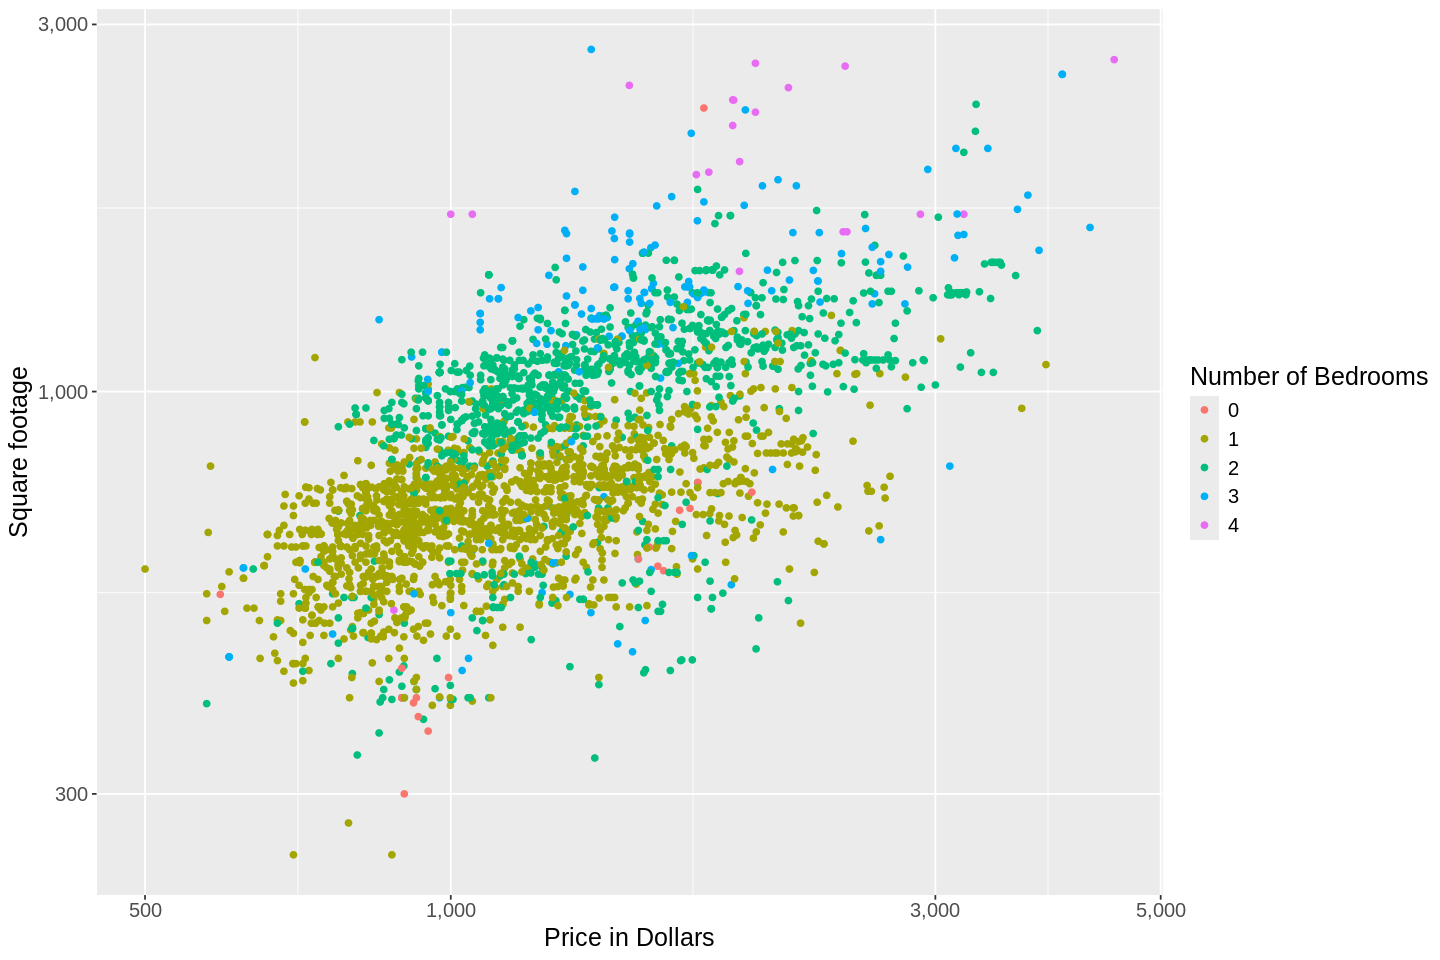

In [24]:
options(repr.plot.width = 12, repr.plot.height = 8) 
price_vs_area <- apt_train |>
                ggplot(aes(x = price, y = square_feet))+
                geom_point(aes(color = as_factor(bedrooms)))+
                labs(x = "Price in Dollars", y = "Square footage", color = "Number of Bedrooms") +
                scale_x_log10(labels = label_comma()) +
                scale_y_log10(labels = label_comma())+
                theme(text = element_text(size = 15))

price_vs_area


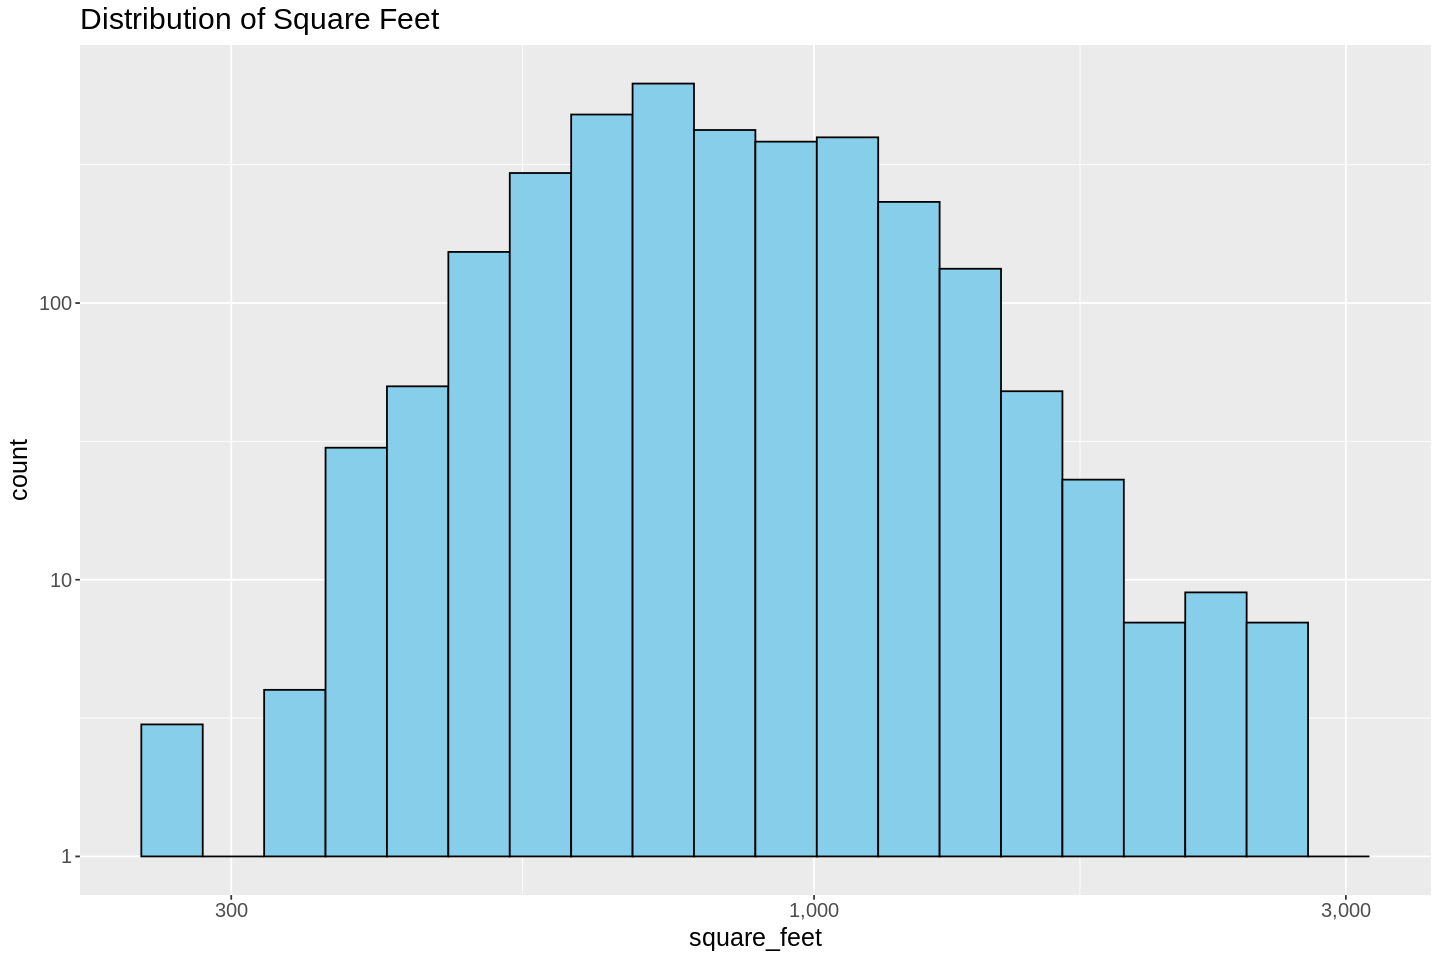

In [25]:
square_footage_dist <- ggplot(data = apt_train) +
  geom_histogram(mapping = aes(x = square_feet), bins = 20, fill = "skyblue", color = "black") +
  labs(title = "Distribution of Square Feet")+
     scale_x_log10(labels = label_comma()) +
                scale_y_log10(labels = label_comma())+
                theme(text = element_text(size = 15))


square_footage_dist